In [1]:
import os
import cv2 as cv
import random as rn
import pandas as pd
import imagesize as im
import matplotlib.pyplot as plt

In [2]:
IMG_FOLDER = 'Images'
LABEL_FOLDER = 'Labels'

In [3]:
df = pd.read_csv('train_df.csv')
df = pd.DataFrame(df)
df['image'] = df['image'].apply(lambda a: os.path.join(IMG_FOLDER, a))
df['label'] = df['label'].apply(lambda a: os.path.join(LABEL_FOLDER, a))
df.head()

,image,label
0,Images\video10_frame_000000.PNG,Labels\video10_frame_000000.txt
1,Images\video10_frame_000001.PNG,Labels\video10_frame_000001.txt
2,Images\video10_frame_000002.PNG,Labels\video10_frame_000002.txt
3,Images\video10_frame_000003.PNG,Labels\video10_frame_000003.txt
4,Images\video10_frame_000004.PNG,Labels\video10_frame_000004.txt


In [4]:
classes = open('classes.txt', 'r').read().split('\n')
classes.remove('')
classes

['Boat',
 'Cargoship',
 'Cruiseship',
 'Ferry',
 'Militaryship',
 'Miscboat',
 'Miscellaneous',
 'Motorboat',
 'Passengership',
 'Sailboat',
 'Seamark']

In [5]:
def read_labels_and_count_classes(a, count):
    with open(a, 'r') as f:
        bboxes = f.read().split('\n')
        bboxes.remove('')
        bboxes = [bbox.split(' ') for bbox in bboxes]
        bboxes = [[int(c), float(x), float(y), float(w), float(h)] for c, x, y, w, h in bboxes]
        for c, x, y, w, h in bboxes:
            count[classes[c]] = count[classes[c]] + 1
        f.close()
    return bboxes
class_count = {c: 0 for c in classes}
df['bbox'] = df['label'].apply(lambda a: read_labels_and_count_classes(a, class_count))
df['keep'] = df['bbox'].apply(lambda a: True if len(a) > 0 else False)
blank_count = dict(df['keep'].value_counts())
df = df.drop(columns=['keep'])
df.head()

,image,label,bbox
0,Images\video10_frame_000000.PNG,Labels\video10_frame_000000.txt,[]
1,Images\video10_frame_000001.PNG,Labels\video10_frame_000001.txt,[]
2,Images\video10_frame_000002.PNG,Labels\video10_frame_000002.txt,[]
3,Images\video10_frame_000003.PNG,Labels\video10_frame_000003.txt,[]
4,Images\video10_frame_000004.PNG,Labels\video10_frame_000004.txt,"[[6, 0.433328, 0.453306, 0.239188, 0.714056]]"


In [6]:
class_count, blank_count

({'Boat': 28737,
  'Cargoship': 9602,
  'Cruiseship': 1075,
  'Ferry': 1213,
  'Militaryship': 2123,
  'Miscboat': 6094,
  'Miscellaneous': 15603,
  'Motorboat': 4160,
  'Passengership': 31756,
  'Sailboat': 60834,
  'Seamark': 4963},
 {True: 88826, False: 1181})

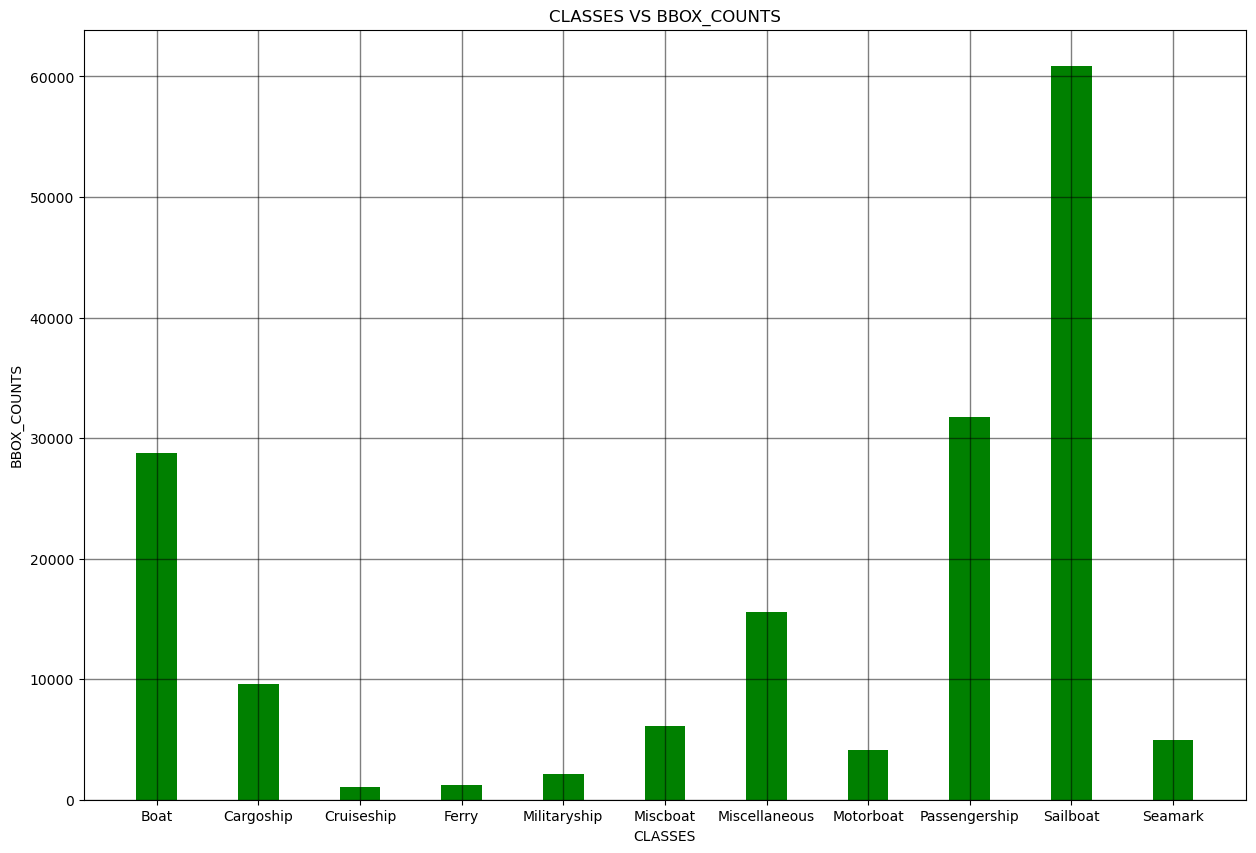

In [7]:
def plot_bar_graph_from_dict(data, xlabel, ylabel, title):
    x = list(data.keys())
    y = list(data.values())
    fig = plt.figure(figsize=(15, 10))
    plt.bar(x, y, color ='green', width=0.4)
    plt.grid(color='black', linewidth=1, axis='both', alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
plot_bar_graph_from_dict(class_count, 'CLASSES', 'BBOX_COUNTS', 'CLASSES VS BBOX_COUNTS')

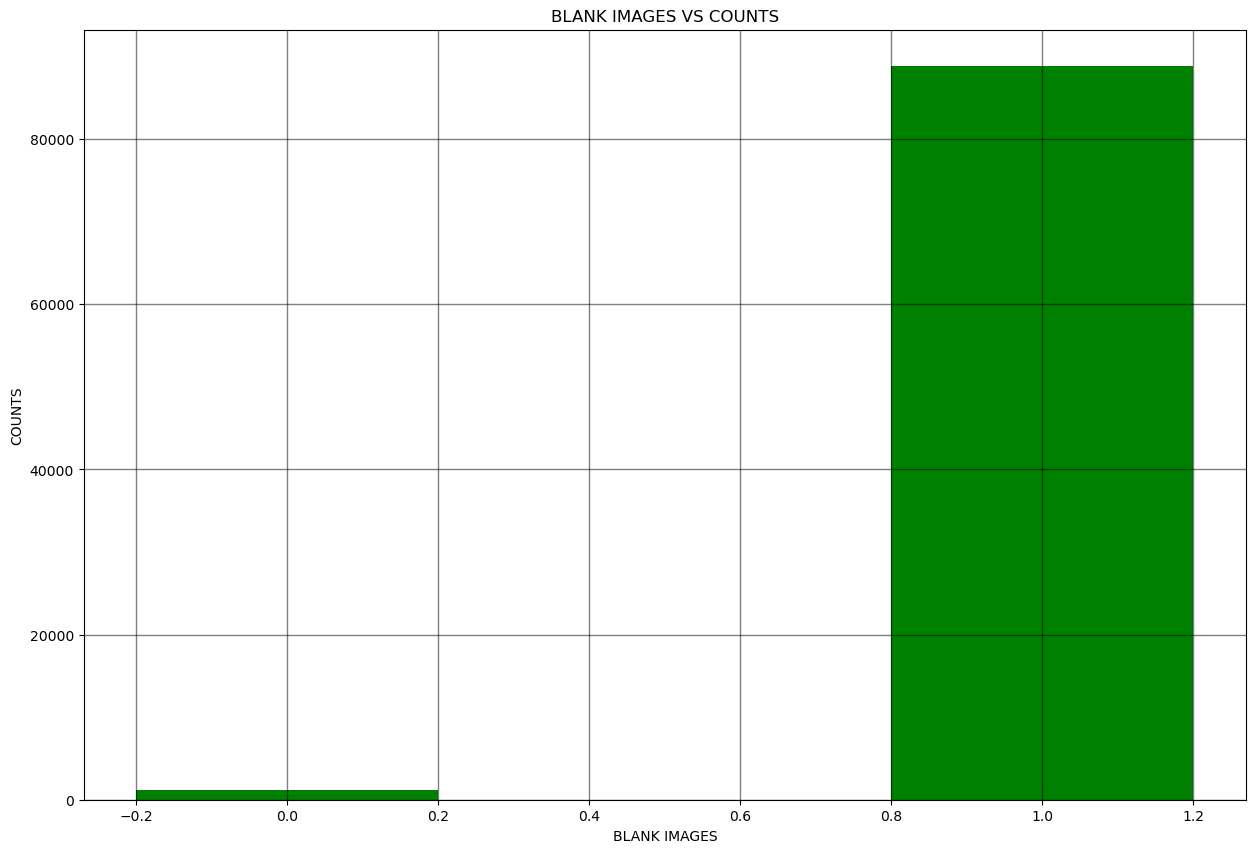

In [8]:
plot_bar_graph_from_dict(blank_count, 'BLANK IMAGES', 'COUNTS', 'BLANK IMAGES VS COUNTS')

In [9]:
# df['img_h'] = df['image'].apply(lambda a: im.get(a))
# df['img_w'] = df['img_h'].apply(lambda a: a[0])
# df['img_h'] = df['img_h'].apply(lambda a: a[1])
# df.describe()

,img_h,img_w
count,90007.0,90007.0
mean,360.0,640.0
std,0.0,0.0
min,360.0,640.0
25%,360.0,640.0
50%,360.0,640.0
75%,360.0,640.0
max,360.0,640.0


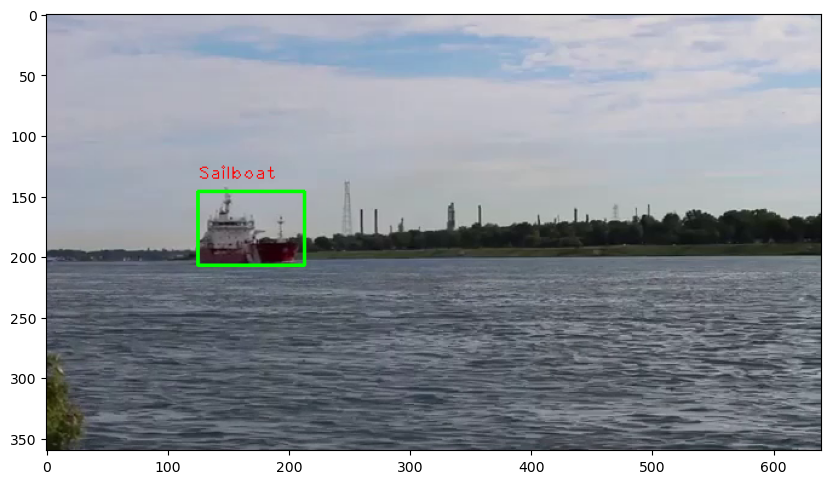

In [10]:
index = rn.randint(0, df.shape[0] - 1)
img_path = df['image'][index]
img = cv.imread(img_path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_h, img_w, _ = img.shape
bboxes = df['bbox'][index]
for c, x, y, w, h in bboxes:
    xmin = int((x - (w / 2.0)) * img_w)
    ymin = int((y - (h / 2.0)) * img_h)
    xmax = int((x + (w / 2.0)) * img_w)
    ymax = int((y + (h / 2.0)) * img_h)
    img = cv.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    img = cv.putText(img, classes[c], (xmin, ymin - 10), cv.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), 1)
plt.figure(figsize=(10, 8))
plt.imshow(img)

In [11]:
def remove_small_bboxes(a, threshold):
    img_w, img_h = im.get(a['image'])
    b = []
    for c, x, y, w, h in a['bbox']:
        if w * h > threshold / (img_h * img_w):
            b.append([c, x, y, w, h])
    with open(a['label'], 'w') as f:
        for bbox in b:
            f.write(f'{c} {x} {y} {w} {h}\n')
        f.close()
    return b
AREA_THRESHOLD = 200
df['bbox'] = df.apply(lambda a: remove_small_bboxes(a, AREA_THRESHOLD), axis=1)
df.head()

,image,label,bbox,img_h,img_w
0,Images\video10_frame_000000.PNG,Labels\video10_frame_000000.txt,[],360,640
1,Images\video10_frame_000001.PNG,Labels\video10_frame_000001.txt,[],360,640
2,Images\video10_frame_000002.PNG,Labels\video10_frame_000002.txt,[],360,640
3,Images\video10_frame_000003.PNG,Labels\video10_frame_000003.txt,[],360,640
4,Images\video10_frame_000004.PNG,Labels\video10_frame_000004.txt,"[[6, 0.433328, 0.453306, 0.239188, 0.714056]]",360,640


In [12]:
def remove_blanks(a):
    if not a['keep']:
        os.remove(a['image'])
        os.remove(a['label'])
df['keep'] = df['bbox'].apply(lambda a: True if len(a) > 0 else False)
df.apply(lambda a: remove_blanks(a), axis=1)
df = df[df['keep'] == True]
df.reset_index(drop=True, inplace=True)
df = df.drop(columns=['keep'])
df.head()

,image,label,bbox,img_h,img_w
0,Images\video10_frame_000004.PNG,Labels\video10_frame_000004.txt,"[[6, 0.433328, 0.453306, 0.239188, 0.714056]]",360,640
1,Images\video10_frame_000005.PNG,Labels\video10_frame_000005.txt,"[[6, 0.447109, 0.451389, 0.269219, 0.713889]]",360,640
2,Images\video10_frame_000006.PNG,Labels\video10_frame_000006.txt,"[[6, 0.453281, 0.448611, 0.284687, 0.713889]]",360,640
3,Images\video10_frame_000007.PNG,Labels\video10_frame_000007.txt,"[[6, 0.451094, 0.445833, 0.280312, 0.713889]]",360,640
4,Images\video10_frame_000008.PNG,Labels\video10_frame_000008.txt,"[[6, 0.444844, 0.445833, 0.270937, 0.713889]]",360,640


In [13]:
class_count = {c: 0 for c in classes}
def count_classes(a, count):
    for c, x, y, w, h in a:
        count[classes[c]] = count[classes[c]] + 1
    return a
df['bbox'] = df['bbox'].apply(lambda a: count_classes(a, class_count))
class_count

{'Boat': 26455,
 'Cargoship': 8333,
 'Cruiseship': 1075,
 'Ferry': 1213,
 'Militaryship': 2118,
 'Miscboat': 6094,
 'Miscellaneous': 15158,
 'Motorboat': 4160,
 'Passengership': 19206,
 'Sailboat': 60834,
 'Seamark': 4963}

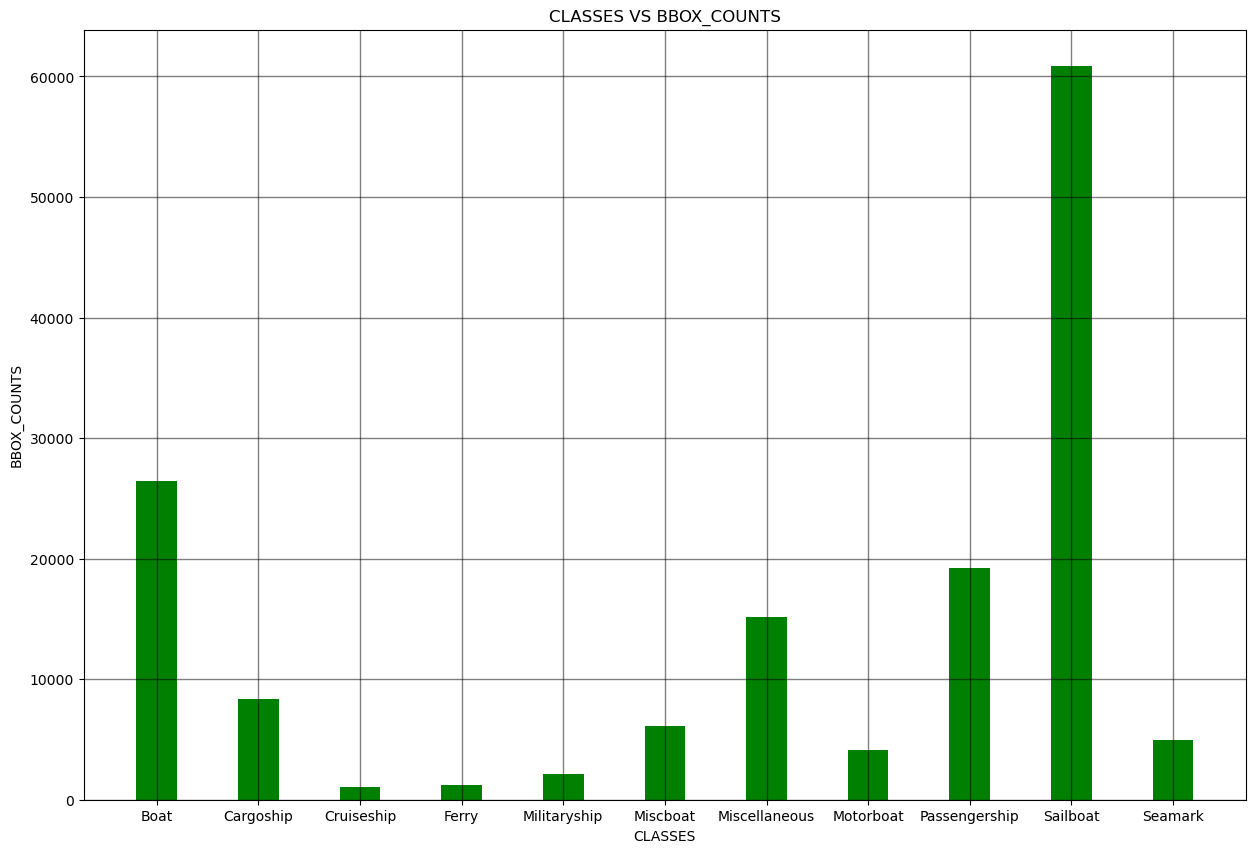

In [14]:
plot_bar_graph_from_dict(class_count, 'CLASSES', 'BBOX_COUNTS', 'CLASSES VS BBOX_COUNTS')

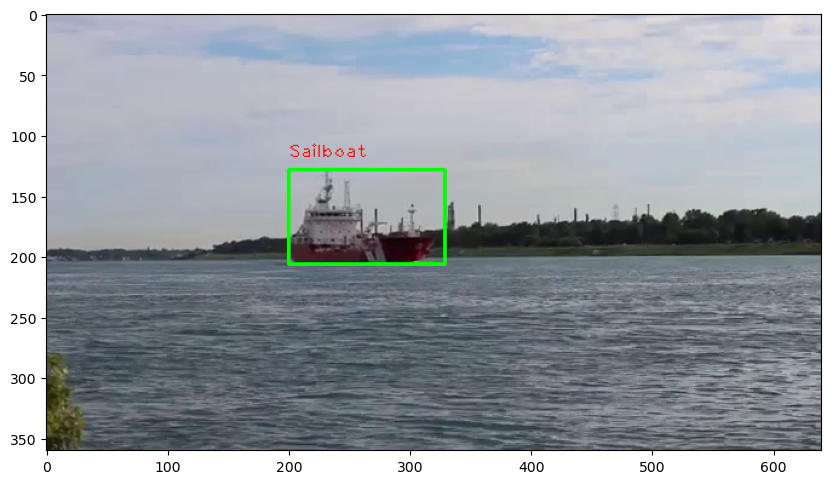

In [15]:
img_path = df['image'][index]
img = cv.imread(img_path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_h, img_w, _ = img.shape
bboxes = df['bbox'][index]
for c, x, y, w, h in bboxes:
    xmin = int((x - (w / 2.0)) * img_w)
    ymin = int((y - (h / 2.0)) * img_h)
    xmax = int((x + (w / 2.0)) * img_w)
    ymax = int((y + (h / 2.0)) * img_h)
    img = cv.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    img = cv.putText(img, classes[c], (xmin, ymin - 10), cv.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), 1)
plt.figure(figsize=(10, 8))
plt.imshow(img)

In [16]:
df = df.drop(columns=['bbox'])
df.to_csv('train_df.csv', index=False)